# Modules

In [ ]:
%load_ext google.colab.data_table

#Packages
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

#Tools
from sklearn import svm
from statistics import mean
from google.colab import drive
from google.colab import data_table
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')

#mount Drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"

#Configuration
pd.set_option('display.max_columns', None)
sns.set_palette("husl", 9)
class_names_complete = ['Sanos', 'Talasemias', 'Hemoglobinopatías', 'A.Ferropénicas', 'A.Crónico']
class_names_reduced = ['Sanos', 'Congénitas', 'Adquiridas']

Mounted at /content/drive


# Data loading

## Train samples

In [ ]:
#Load CSV fie
CBC_file_dir = root_dir + "Data/ProcessedData-2021-Filtrados.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
CBC["Clase"] = CBC["Clase"].astype(int)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))

File loaded, shape:(3295, 18)


In [ ]:
#Check 100 samples
data_table.DataTable(CBC.head(100), include_index=False, num_rows_per_page=10)

,Edad,WBC,LYAB,MOAB,NEAB,EO,BA,HEMA,HGB,HTO,VCM,MCH,CHCM,RDW,PLT,VPM,Clase,TipoClase
0,0.117647,0.145740,0.075908,0.250000,0.118182,0.351429,0.122807,0.376455,0.605882,0.530957,0.451574,0.455738,0.715385,0.068493,0.089410,0.557692,0,-1.0
1,0.519608,0.087444,0.049505,0.107143,0.090909,0.034286,0.087719,0.331177,0.582353,0.491557,0.483051,0.504918,0.769231,0.037671,0.099826,0.259615,0,-1.0
2,0.441176,0.132287,0.029703,0.214286,0.186364,0.065714,0.245614,0.469599,0.647059,0.579737,0.366828,0.367213,0.676923,0.157534,0.231771,0.250000,0,-1.0
3,0.754902,0.177130,0.016502,0.142857,0.318182,0.005714,0.000000,0.291074,0.458824,0.382739,0.395884,0.413115,0.723077,0.157534,0.211806,0.307692,0,-1.0
4,0.666667,0.161435,0.066007,0.214286,0.195455,0.108571,0.122807,0.397154,0.694118,0.604128,0.515738,0.527869,0.746154,0.130137,0.150174,0.346154,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.784314,0.304933,0.110398,0.217705,0.184689,0.028571,0.350877,0.278137,0.629412,0.568480,0.727603,0.681967,0.661538,0.335616,0.163194,0.365385,0,-1.0
96,0.480392,0.109865,0.033003,0.285714,0.118182,0.174286,0.403509,0.363519,0.652941,0.527205,0.470944,0.537705,0.869231,0.109589,0.198785,0.413462,0,-1.0
97,0.833333,0.426009,0.264026,0.285714,0.459091,0.008571,0.035088,0.510996,0.682353,0.632270,0.369249,0.350820,0.623077,0.106164,0.196181,0.365385,0,-1.0
98,0.656863,0.154709,0.056106,0.178571,0.204545,0.082857,0.087719,0.454075,0.741176,0.643527,0.467312,0.488525,0.761538,0.089041,0.179688,0.461538,0,-1.0


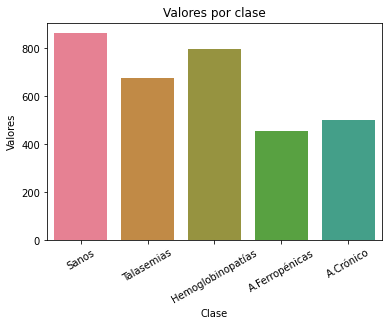

In [ ]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_complete, rotation=30, fontsize=10);

## Validation Samples

In [ ]:
#Load CSV fie
CBCVal21_file_dir = root_dir + "Data/POST-ProcessedData-2021-Filtrados.csv"
CBCVal21 = pd.read_csv(CBCVal21_file_dir, error_bad_lines=True)
CBCVal21["Clase"] = CBCVal21["Clase"].astype(int)
print('File loaded, TEST, shape:(%s, %s)' %((len(CBCVal21), len(CBCVal21.iloc[0]))))

File loaded, TEST, shape:(221, 18)


In [ ]:
#Check 100 samples
data_table.DataTable(CBCVal21.head(100), include_index=False, num_rows_per_page=10)

,Edad,WBC,LYAB,MOAB,NEAB,EO,BA,HEMA,HGB,HTO,VCM,MCH,CHCM,RDW,PLT,VPM,Clase,TipoClase
0,0.504132,0.190909,0.324324,0.260870,0.137195,0.276471,0.081967,0.567568,0.828571,0.748503,0.861171,0.909574,0.909910,0.036036,0.192825,0.400000,0,-1.0
1,0.636364,0.206061,0.108108,0.347826,0.201220,0.088235,0.131148,0.585586,0.780952,0.715569,0.778742,0.824468,0.882883,0.049550,0.203288,0.542857,0,-1.0
2,0.677686,0.145455,0.067568,0.217391,0.158537,0.135294,0.147541,0.387387,0.523810,0.502994,0.828633,0.840426,0.837838,0.076577,0.303438,0.385714,0,-1.0
3,0.305785,0.366667,0.189189,0.304348,0.347561,0.035294,0.065574,0.635135,0.809524,0.769461,0.767896,0.787234,0.828829,0.031532,0.124066,0.514286,0,-1.0
4,0.239669,0.109091,0.094595,0.173913,0.121951,0.117647,0.114754,0.484234,0.666667,0.628743,0.837310,0.851064,0.846847,0.022523,0.101644,0.828571,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.081818,0.121622,0.173913,0.085366,0.247059,0.065574,0.123874,0.228571,0.200599,0.893709,0.946809,0.918919,0.000000,0.092676,0.871429,4,2.0
96,0.743802,0.157576,0.189189,0.260870,0.143293,0.047059,0.081967,0.236486,0.257143,0.287425,0.765727,0.734043,0.729730,0.081081,0.153961,0.428571,4,2.0
97,0.752066,0.000000,0.027027,0.130435,0.030488,0.147059,0.360656,0.182432,0.247619,0.269461,0.882863,0.845745,0.756757,0.022523,0.182362,0.414286,4,2.0
98,0.801653,0.066667,0.189189,0.173913,0.057927,0.111765,0.049180,0.189189,0.314286,0.317365,0.969631,0.930851,0.783784,0.009009,0.234679,0.314286,4,2.0


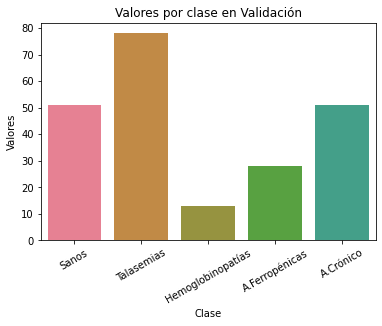

In [ ]:
chart = sns.countplot(x='Clase', data=CBCVal21)
plt.ylabel("Valores")
plt.title('Valores por clase en Validación')
chart.set_xticklabels(class_names_complete, rotation=30, fontsize=10);

# Data Selection

In [ ]:
#Select classes we are going to work with
#In this case, we merge in 3 subgroups: Sanos, Congenitas and Adquiridas

CBC = CBC[CBC['Clase'] != 2] 
#CBC['Clase'] = CBC['Clase'].replace(to_replace = 2, value = 1)
CBC['Clase'] = CBC['Clase'].replace(to_replace = 3, value = 2) 
CBC['Clase'] = CBC['Clase'].replace(to_replace = 4, value = 2) 

In [ ]:
healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
anemias = CBC.loc[CBC['Clase'] == 2]

#Pick only specific thalassemias
#thalassemias = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBC = pd.concat([healthy,thalassemias, anemias])
print(CBC['Clase'].value_counts(sort=False))

0    863
2    959
1    675
Name: Clase, dtype: int64


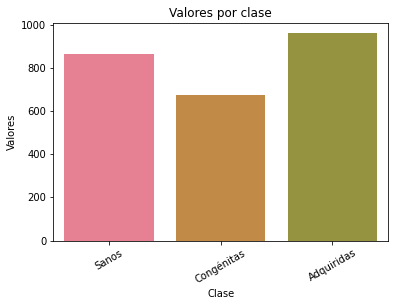

In [ ]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_reduced, rotation=30, fontsize=10);

In [ ]:
#Test
#CBCVal21 = CBCVal21[CBCVal21['Clase'] != 2]
CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 2, value = 1)
CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 3, value = 2) 
CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 4, value = 2) 

In [ ]:
healthyVal = CBCVal21.loc[CBCVal21['Clase'] == 0]
thalassemiasVal = CBCVal21.loc[CBCVal21['Clase'] == 1]
anemiasVal = CBCVal21.loc[CBCVal21['Clase'] == 2]

#Pick only specific thalassemias
#thalassemiasVal = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBCVal21 = pd.concat([healthyVal,thalassemiasVal, anemiasVal])
print(CBCVal21['Clase'].value_counts())

1    91
2    79
0    51
Name: Clase, dtype: int64


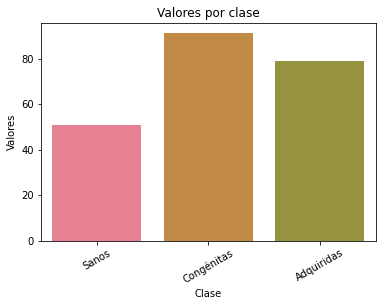

In [ ]:
chart = sns.countplot(x='Clase', data=CBCVal21)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_reduced, rotation=30, fontsize=10);

## Separating labels


In [ ]:
#Train
CBC = CBC.sample(frac = 1)

labels = CBC['Clase']
CBC = CBC.drop('Clase', axis=1)
CBC = CBC.drop('TipoClase', axis=1)
CBC.replace(0,CBC.mean(axis=0),inplace=True)

In [ ]:
#Test
CBCVal21 = CBCVal21.sample(frac = 1)

labelsVal = CBCVal21['Clase']
CBCVal21 = CBCVal21.drop('Clase', axis=1)
CBCVal21 = CBCVal21.drop('TipoClase', axis=1)
CBCVal21.replace(0,CBCVal21.mean(axis=0),inplace=True)

In [ ]:
print(CBC.columns)

Index(['Edad', 'WBC', 'LYAB', 'MOAB', 'NEAB', 'EO', 'BA', 'HEMA', 'HGB', 'HTO',
       'VCM', 'MCH', 'CHCM', 'RDW', 'PLT', 'VPM'],
      dtype='object')


In [ ]:
CBC = CBC.to_numpy()
CBCVal21 = CBCVal21.to_numpy()

# Model Selection

In [ ]:
def calculateOptimalSVM(data, original_labels):

    X = data
    y = original_labels

    models = (svm.SVC(kernel='linear', class_weight='balanced'),
              svm.LinearSVC(dual=False, class_weight='balanced'),
              svm.SVC(kernel='rbf', class_weight='balanced'),
             svm.SVC(kernel='poly', class_weight='balanced'),)
    
    models_score = (cross_val_score(model, CBC, labels, cv=10) for model in models)

    best_model = []
    best_score = 0
    for model in models:
      score = mean(cross_val_score(model, CBC, labels, cv=10))
      if (score > best_score):
          best_model = model
          best_score = score

    print('Best performing model is -', best_model.get_params()['kernel'], '- with a score of ', best_score)
    return  (best_model.get_params()['kernel'])

In [ ]:
best_kernel = calculateOptimalSVM(CBC,labels)

Best performing model is - rbf - with a score of  0.8726409638554217


In [ ]:
def calculateBestParamsRBF(data, original_labels, best_kernel):

  X_train, X_test, y_train, y_test = train_test_split(CBC, labels, test_size = 0.2)
  param_grid = {'C': [7, 9, 10, 12], 'gamma': [1.1, 1, 1.2], 'kernel': [best_kernel], 'class_weight':['balanced']} 
  grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1, cv=5)
  grid.fit(X_train, y_train)
  print(grid.best_params_)

  return (grid.best_params_)

In [ ]:
best_params = calculateBestParamsRBF(CBC,labels,best_kernel)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 9, 'class_weight': 'balanced', 'gamma': 1.2, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.7s finished


In [ ]:
def calculateSVM(data, original_labels, best_params):
  model = svm.SVC(kernel=best_params['kernel'], gamma=best_params['gamma'], C=best_params['C'], class_weight='balanced')
  scores = cross_val_score(model, CBC, labels, cv=10)
  print('Best score: ', mean(scores))

  #Train
  x_train, x_test, y_train, y_test = train_test_split(CBC, labels, test_size=0.10)
  svc = model.fit(x_train,y_train)
  y_pred = svc.predict(x_test)

  con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm, index = class_names_reduced, columns = class_names_reduced)

  print('Accuracy Y_test: ', accuracy_score(y_test, y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('Etiqueta real')
  plt.xlabel('Etiqueta predicha')
  plt.show()


  #2021 Validation
  x_val, y_val = shuffle(CBCVal21, labelsVal)
  y_pred = svc.predict(x_val)

  con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm, index = class_names_reduced, columns = class_names_reduced)
  
  print('Accuracy Y_Val: ', accuracy_score(y_val, y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# Results

Best score:  0.8722361445783132
Accuracy Y_test:  0.882


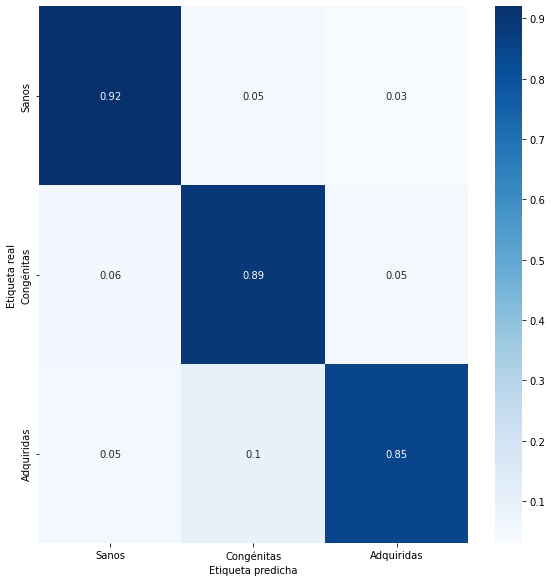

Accuracy Y_Val:  0.7647058823529411


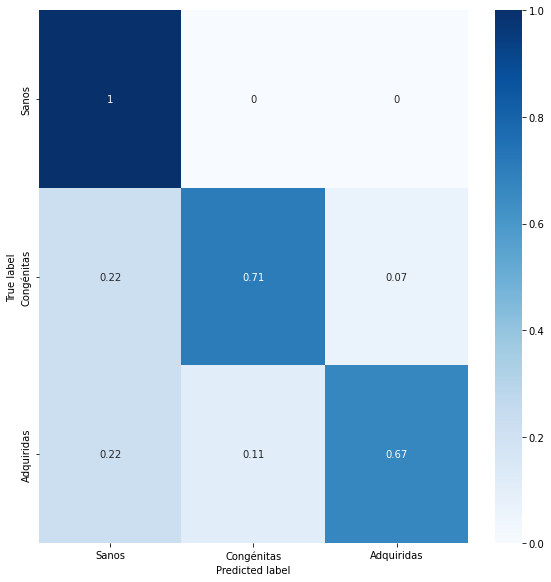

In [ ]:
calculateSVM(CBC,labels,best_params)